## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 
For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [177]:
#importing libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [178]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [179]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [180]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [181]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [182]:
#number of times 'new_page' doesn't meet with 'treatment':
count1=df[(df['landing_page']=='new_page') & (df['group']!='treatment')].shape[0]

#number of times 'old_page' doesn't meet with 'control':
count2=mismatched_dataset_2=df[(df['landing_page']=='old_page') & (df['group']!='control')].shape[0]

#Total rows 
count1+count2

3893

f. Do any of the rows have missing values?

In [183]:
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [184]:
#Making a copy of original dataframe
df2=df.copy()

#Getting indexes of all the rows where 'new_page' doesn't meet with 'treatment'
data_mismatch_indexs_1=df[(df['landing_page']=='new_page') & (df['group']!='treatment')].index

#Getting indexes of all the rows where 'old_page' doesn't meet with 'control'
data_mismatch_indexs_2=df[(df['landing_page']=='old_page') & (df['group']!='control')].index


In [185]:
#droping all the indexes where 'new_page' does not meet with 'treatment'
df2.drop(data_mismatch_indexs_1,inplace=True)

#droping all the indexes where 'old_page' does not meet with 'control'
df2.drop(data_mismatch_indexs_2,inplace=True)

In [186]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [187]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [188]:
df2[df2.duplicated('user_id',keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [189]:
#Saving index of it
duplicated_row_index=df2[df2.duplicated('user_id')].index[0]

c. What is the row information for the repeat **user_id**? 

In [190]:
df2.loc[duplicated_row_index]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [191]:
df2.drop(duplicated_row_index,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [192]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [193]:
obs_old=df2.query("group=='control'")['converted'].mean()
obs_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [194]:
obs_new=df2.query("group=='treatment'")['converted'].mean()
obs_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [195]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**Answer:** 
>*     We can not conclude the result just by examining a sample iteslf. There could be many reasons behind it. For example change aversion, experiment duration etc.
>
>
>*     We learnt that sampling distribution technique leads us closer to the parameter value. So before concluding which page has got higher conversion rate, we would be doing sampling distribution of our sample dataset and then we would be concluding the result.
>
>
>*    If we talk about this sample dataset, we see a marginal difference in conversion rate of the pages. Conversion rate of old page a bit higher than conversion rate of new page.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

*    $H_{0}$: **$p_{new}$** <= **$p_{old}$** 
*    $H_{1}$: **$p_{new}$** > **$p_{old}$** 

</br>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [196]:
# As stated above, conversion rate of new page is equal to overall conversion rate of the sample so
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [197]:
# As stated above, conversion rate of old page is equal to conversion rate of new page and overall conversion rate of the sample
p_old=p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [198]:
n_new=df2[df2['group']=='treatment']['user_id'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [199]:
n_old=df2[df2['group']=='control']['user_id'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [200]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [201]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [202]:
p_diff= new_page_converted.mean()-old_page_converted.mean()
p_diff

0.00075512901471463945

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [203]:
p_diffs=[]
for _ in range(10000):
    bootstrap_new= np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
    bootstrap_old= np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
    
    #calculating mean
    bootsrtap_new_mean=bootstrap_new.mean()
    bootstrap_old_mean=bootstrap_old.mean()
    
    #Calculating difference
    p_diff=bootsrtap_new_mean-bootstrap_old_mean
    
    #appending the result to the list 
    p_diffs.append(p_diff)

    
#Converting list into array
p_diffs=np.array(p_diffs)

    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

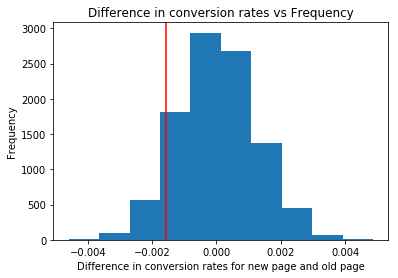

In [204]:
plt.hist(p_diffs);
plt.xlabel('Difference in conversion rates for new page and old page');
plt.ylabel('Frequency')
plt.title('Difference in conversion rates vs Frequency')

#ploting observed difference in histogram
obs_diff=obs_new-obs_old
plt.axvline(x=obs_diff,color='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [205]:
(p_diffs>obs_diff).mean()

0.90759999999999996

In [206]:
#Computing z value
z_score=(obs_diff-0)/p_diffs.std()
z_score

-1.3060514142852944

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**Answer:**
>*    In this second part of the project, firstly we created our null hypothesis ($H_{0}$) and alternate hypothesis ($H_{1}$)
>
>
>*    Now, we found the probability of getting "Obs_diff" if our null hypothesis is true. This probability is also called **p_value**. 
>
>
>*    To do this we followed the following steps:
        *    We assumed that our null hypothesis ($H_{0}$) is true.
        *    Then we performed the sampling distributions and generated 10,000 samples and then found the difference in mean conversion rates of the the old page and the new page from each sample. All these values are then stored in a list named **p_diffs** and then converted this list to an array.
        *    Then we found the probablity of getting "obs_diff". Which came out as 0.9081. i.e **p_value**=0.9081
>
>
>*     Our significance value or alpha value is 0.05 (5%) and p value is 0.90. Here the p_value is greater than the significance value so we fail to reject our null hypothesis. It means that we consider that the conversion rate of the old page and the new page to be the same.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [207]:
import statsmodels.api as sm

convert_old =df2.query("landing_page=='old_page' and converted==1").shape[0]
convert_new =df2.query("landing_page=='new_page' and converted==1").shape[0]
n_old = df2.query("landing_page=='old_page'").shape[0]
n_new = df2.query("landing_page=='new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [208]:
sm.stats.proportions_ztest(count=[convert_new,convert_old],nobs=[n_new,n_old],alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**Answer:**
>*     **Z score** is the distance of our observed data to the mean value in terms of standard deviation. There is inverse relationship between **p_value** and **Z score**. Here **Z score** is -1.31 which suggests that our observed value ("obs_diff") is 1.31 standard deviation away from the mean value. 
>
>
>*     Here **Z score** is negative which states that our "obs_diff" lies left to the mean value i.e it is lesser than the mean value.
>
>
>*      Here the meaning of the **p_value** is same as stated above in the previous question.
>
>
>*     **p_value**  and **z_score** stays almost same as we computed before.

</br>

</br>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Answer:**
>*    1) As the result is either conversion or no conversion so we would be performing logistic regression in this case.

</br>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [209]:
#Adding column 'intercept' in the dataframe
df2['intercept']=1

In [210]:
#Create dummies
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [211]:
lm=sm.OLS(df2['converted'],df2[['intercept','ab_page']])
result=lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [212]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Fri, 08 Mar 2019   Prob (F-statistic):              0.190
Time:                        20:37:42   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**


>In regression model, hypothesis is defined in this way:
>*       $H_{0}$: **$p_{new}$** - **$p_{old}$** =0  
>*       $H_{1}$: **$p_{new}$** - **$p_{old}$** !=0


>Wherd as, in Part II , hypothesis was defined in this way:
>*    $H_{0}$: **$p_{new}$** <= **$p_{old}$** 
>*    $H_{1}$: **$p_{new}$** > **$p_{old}$** 


>*    In technical terms, in the regression model, we are doing two tail test on the **$p_{new}$** where as in Part-II we performed one tail test. And this is why we got different **p_value** here.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer:**
>*      Considering other factors into the regression model has both advantages and disadvantages. 
>
>
>*      You would like to have higher $R^{2}$ value. $R^{2}$ value represents variablity of response variable which you can estimate or predict by your explanatory variables. Higher tha value of it, better the chances of predicting the response variable by the expanatory variables. So if we feel that the current $R^{2}$ value is not quite good then we can add more variables in expnatory variables to check if it surges $R^{2}$ value.
>
>
>*      Sometimes adding more variables in th regression model makes it unstable and it generates wrong predictions. It happens when there is multicollinearity among the explanatory variables. multicollinearity among variables means linear relationshisp between its variables. So it can awfully mispredict the outcomes. So before adding mutiple variables on the x-axis, it is wise  to check if multicollinearity exists in the variables. Ploting graph between explanatory variabels and calculating VIF are two ways to check it.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [213]:
#reading countries dataset and storing it in new dataframe d3
df3=pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [214]:
#Joining df2 and df3 dataframe
df4=df2.join(df3, lsuffix='user_id',rsuffix='user_id', how='inner')
df4.head()

,user_iduser_id,timestamp,group,landing_page,converted,intercept,ab_page,user_iduser_id,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,834778,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,928468,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,822059,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,711597,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,710616,UK


In [215]:
#renaming 'user_iduser_id' feature to 'user_id'
df4.rename(columns={'user_iduser_id':'user_id'},inplace=True)

In [216]:
#creating dummy variables for country feature and adding them to df4 dataframe.
df4=df4.join(pd.get_dummies(df4['country']))
df4.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,user_id,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,834778,UK,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,928468,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,822059,UK,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [217]:
lm=sm.OLS(df4['converted'],df4[['intercept','ab_page','UK','US']])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.064
Date:                Fri, 08 Mar 2019   Prob (F-statistic):              0.363
Time:                        20:37:42   Log-Likelihood:                -84159.
No. Observations:              286742   AIC:                         1.683e+05
Df Residuals:                  286738   BIC:                         1.684e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1177      0.003     42.346      0.000       0.112       0.123
ab_page       -0.0017      0.001     -1.376      0.169      -0.004       0.001
UK             0.0034      0.003      1.135      0.257      -0.002       0.009
US             0.0027      0.003      0.967      0.334      -0.003       0.008
==============================================================================
Omnibus:                   123871.913   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           408655.692
Skew:                           2.344   Prob(JB):                         0.00
Kurtosis:                       6.496   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**Answer:**
>*    **p_value** of all the explanatory dummy variables are higher than alpha value(0.05) which states that none of the varable is significant to the baseline (CA) and they do not make any impact on the response variable. In other words countries do not impact the conversion rate.

>*    **p_value** of ab_page is higher than alpha value(0.05) which states that $p_{ab-page}$ is not significant so we consider that it doesn't make any impact on response variable.In other words the  conversion rate of new_page and old_page stays same.
>
>
>In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [218]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0